In [ ]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=fa394a864826aab8fd485ba2d4cd592420700645e144e5be6ba10360c3360108
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=24c6e24eca89ab59de7aaaa91ea12c95aac2644911646a9448227611450c12f9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [ ]:
import os
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
zip_rgb_pm_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Dataset/SLP_Dataset_RGB_PM/RGM_PM(Train_Val).zip'
unzip_rgb_pm_path = '/content/RGB_PM'

os.makedirs(unzip_rgb_pm_path, exist_ok=True)
with zipfile.ZipFile(zip_rgb_pm_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_rgb_pm_path)

# 데이터셋

In [ ]:
class RGB_PM_Dataset_Segmentation(Dataset):
    """
    RGB 이미지와 압력맵(PM) 이미지를 불러와서 변환하는 데이터셋 클래스입니다.
    압력맵 이미지를 세그멘테이션에 활용할 수 있도록, 압력 값의 범위에 따라서 라벨을 지정합니다.
    """
    def __init__(self, rgb_pm_folder, rgb_transform=None, pm_transform=None):
        self.rgb_pm_folder = rgb_pm_folder

        self.rgb_images = sorted([f for f in os.listdir(self.rgb_pm_folder) if f.endswith('.jpg')])
        self.pm_images = sorted([f for f in os.listdir(self.rgb_pm_folder) if f.endswith('.png')])

        self.rgb_transform = rgb_transform
        self.pm_transform = pm_transform

        # 압력 맵을 세그멘테이션 클래스 레이블로 변환할 임계값 목록 정의
        self.threshold = [0, 10, 50, 100, 150, 200, 255]

    def __len__(self):
        return len(self.pm_images)

    def __getitem__(self, idx):
        # RGB image
        rgb_path = os.path.join(self.rgb_pm_folder, self.rgb_images[idx])
        rgb_img = Image.open(rgb_path).convert('RGB')
        rgb_img = self.rgb_transform(rgb_img)

        # Pressure map
        pm_path = os.path.join(self.rgb_pm_folder, self.pm_images[idx])
        pm_img = Image.open(pm_path)
        pm_img = self.pm_transform(pm_img)
        pm_img = torch.tensor(np.array(pm_img), dtype=torch.float32)
        pm_img = self.convert_pressure_map(pm_img.squeeze(0))

        return rgb_img, pm_img

    def convert_pressure_map(self, image):
        """
        압력 맵 이미지를 세그멘테이션 레이블로 변환하는 메서드.
        주어진 임계값에 따라 압력 맵을 클래스 레이블로 나누어 반환 (클래스는 총 6개).
        """

        segmentation_image = torch.zeros((image.shape[0], image.shape[1]), dtype=torch.long)

        for i in range(len(self.threshold) - 1):
            mask = (image >= self.threshold[i]) & (image < self.threshold[i + 1])
            segmentation_image[mask] = i

        return segmentation_image

In [ ]:
rgb_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((192, 96)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

pm_transform = transforms.Compose([transforms.Resize((192, 96))])

In [ ]:
val_data_path = os.path.join(unzip_rgb_pm_path, 'Validation')

train_dataset = RGB_PM_Dataset_Segmentation(unzip_rgb_pm_path, rgb_transform, pm_transform)
val_dataset = RGB_PM_Dataset_Segmentation(val_data_path, rgb_transform, pm_transform)

In [ ]:
print('Train 샘플 개수:', len(train_dataset))
print('Val 샘플 개수:', len(val_dataset))

Train 샘플 개수: 4050
Val 샘플 개수: 450


In [ ]:
"""
RGB 이미지, 훈련 데이터가 약 4천장이므로, 배치 크기는 16으로 설정
"""

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)

In [ ]:
print('Train 배치 개수:', len(train_loader))
print('Val 배치 개수:', len(val_loader))

Train 배치 개수: 254
Val 배치 개수: 29


In [ ]:
rgb_sample, pm_sample = next(iter(train_loader))

rgb_sample = rgb_sample[0]
pm_sample = pm_sample[0]

In [ ]:
print('RGB image shape:', rgb_sample.shape)
print('Pressure map shape:', pm_sample.shape)

RGB image shape: torch.Size([3, 192, 96])
Pressure map shape: torch.Size([192, 96])


Text(0.5, 1.0, 'Pressure Map (Ground Truth)')

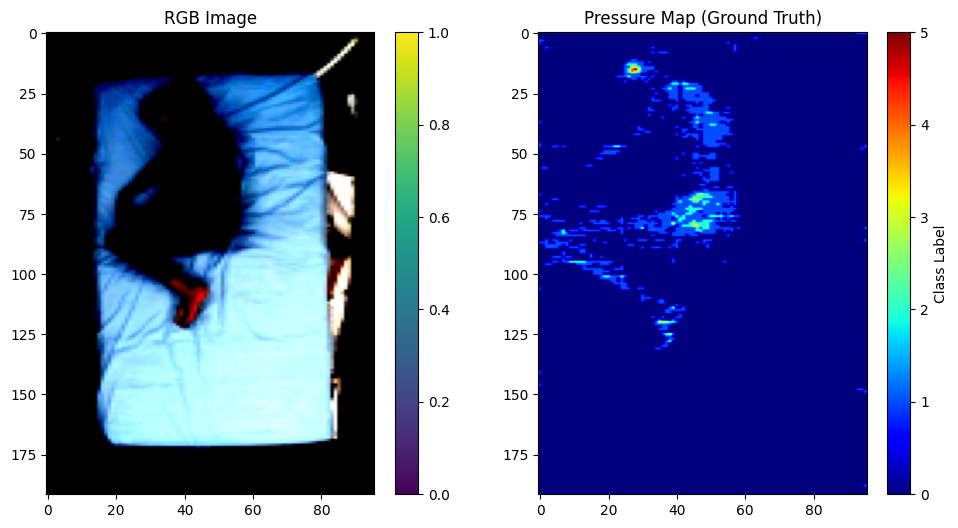

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(rgb_sample.permute(1, 2, 0), aspect='auto')
plt.colorbar()
plt.title('RGB Image')

plt.subplot(1, 3, 2)
plt.imshow(pm_sample, cmap='jet', aspect='auto')
plt.colorbar(label='Class Label')
plt.title('Pressure Map (Ground Truth)')

# 모델

In [ ]:
"""
U-Net 모델을 생성
encoder_name="resnet50": U-Net의 백본으로 ResNet50을 사용
encoder_weights="imagenet": ResNet50의 가중치는 ImageNet에서 학습된 가중치를 사용
in_channels=3: 입력 이미지 채널 수 (RGB 이미지이므로 3)
classes=1: 출력 클래스 수 (압력 레이블에 대한 세그멘테이션이므로 클래스 수는 6)
"""

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=6
)

model = model.to(device)

In [ ]:
print(model)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")

Total Parameters: 24437094


In [ ]:
criterion = nn.CrossEntropyLoss() # 세그멘테이션이므로 크로스 엔트로피 손실 사용
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train(model, data_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(data_loader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(data_loader)

    return train_loss

In [ ]:
def evaluate(model, data_loader, criterion):
    model.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            eval_loss += loss.item()

    eval_loss /= len(data_loader)

    return eval_loss

In [ ]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss = train(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)

    val_loss = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)

    print(f"Training Loss: {train_loss:.6f} | Validation Loss: {val_loss:.6f}\n")

Epoch 1/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.507483 | Validation Loss: 0.288202

Epoch 2/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.239596 | Validation Loss: 0.228832

Epoch 3/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.200650 | Validation Loss: 0.211924

Epoch 4/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.182762 | Validation Loss: 0.203042

Epoch 5/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.172181 | Validation Loss: 0.198310

Epoch 6/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.164612 | Validation Loss: 0.197113

Epoch 7/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.158528 | Validation Loss: 0.193418

Epoch 8/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.153700 | Validation Loss: 0.195395

Epoch 9/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.149690 | Validation Loss: 0.198077

Epoch 10/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.147040 | Validation Loss: 0.193775

Epoch 11/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.143786 | Validation Loss: 0.195633

Epoch 12/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.141136 | Validation Loss: 0.190480

Epoch 13/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.138805 | Validation Loss: 0.192173

Epoch 14/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.137220 | Validation Loss: 0.195252

Epoch 15/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.135456 | Validation Loss: 0.195046

Epoch 16/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.133838 | Validation Loss: 0.195232

Epoch 17/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.132190 | Validation Loss: 0.197298

Epoch 18/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.130598 | Validation Loss: 0.199165

Epoch 19/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.128880 | Validation Loss: 0.197674

Epoch 20/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.128524 | Validation Loss: 0.197401

Epoch 21/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.126824 | Validation Loss: 0.199366

Epoch 22/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.125164 | Validation Loss: 0.198772

Epoch 23/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.123956 | Validation Loss: 0.200331

Epoch 24/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.122774 | Validation Loss: 0.200192

Epoch 25/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.122054 | Validation Loss: 0.203392

Epoch 26/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.121053 | Validation Loss: 0.201891

Epoch 27/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.119997 | Validation Loss: 0.204654

Epoch 28/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.118928 | Validation Loss: 0.204906

Epoch 29/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.117876 | Validation Loss: 0.209669

Epoch 30/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.117155 | Validation Loss: 0.207505

Epoch 31/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.116300 | Validation Loss: 0.209999

Epoch 32/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.115470 | Validation Loss: 0.207310

Epoch 33/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.114280 | Validation Loss: 0.209536

Epoch 34/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.113128 | Validation Loss: 0.209585

Epoch 35/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.112344 | Validation Loss: 0.206897

Epoch 36/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.111538 | Validation Loss: 0.214781

Epoch 37/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.110580 | Validation Loss: 0.214968

Epoch 38/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.109919 | Validation Loss: 0.215202

Epoch 39/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.109127 | Validation Loss: 0.216121

Epoch 40/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.108525 | Validation Loss: 0.217500

Epoch 41/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.107832 | Validation Loss: 0.214125

Epoch 42/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.106611 | Validation Loss: 0.214973

Epoch 43/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.105712 | Validation Loss: 0.218401

Epoch 44/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.105138 | Validation Loss: 0.225988

Epoch 45/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.104196 | Validation Loss: 0.218757

Epoch 46/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.103202 | Validation Loss: 0.224730

Epoch 47/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.102574 | Validation Loss: 0.222045

Epoch 48/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.101567 | Validation Loss: 0.222917

Epoch 49/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.101167 | Validation Loss: 0.226210

Epoch 50/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.100314 | Validation Loss: 0.231700

Epoch 51/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.100073 | Validation Loss: 0.225368

Epoch 52/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.099423 | Validation Loss: 0.229988

Epoch 53/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.098450 | Validation Loss: 0.232797

Epoch 54/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.097811 | Validation Loss: 0.230342

Epoch 55/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.097421 | Validation Loss: 0.239704

Epoch 56/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.096370 | Validation Loss: 0.239471

Epoch 57/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.095423 | Validation Loss: 0.236650

Epoch 58/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.094757 | Validation Loss: 0.242486

Epoch 59/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.094411 | Validation Loss: 0.237718

Epoch 60/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.093625 | Validation Loss: 0.245655

Epoch 61/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.093207 | Validation Loss: 0.245686

Epoch 62/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.092515 | Validation Loss: 0.243213

Epoch 63/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.091789 | Validation Loss: 0.242995

Epoch 64/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.091578 | Validation Loss: 0.243690

Epoch 65/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.090869 | Validation Loss: 0.250216

Epoch 66/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.090249 | Validation Loss: 0.250717

Epoch 67/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.089645 | Validation Loss: 0.248060

Epoch 68/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.089653 | Validation Loss: 0.248209

Epoch 69/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.090310 | Validation Loss: 0.250333

Epoch 70/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.088134 | Validation Loss: 0.255630

Epoch 71/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.087156 | Validation Loss: 0.258664

Epoch 72/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.086766 | Validation Loss: 0.254224

Epoch 73/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.086474 | Validation Loss: 0.255595

Epoch 74/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.086394 | Validation Loss: 0.259483

Epoch 75/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.085498 | Validation Loss: 0.263732

Epoch 76/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.084777 | Validation Loss: 0.259571

Epoch 77/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.084473 | Validation Loss: 0.263800

Epoch 78/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.083989 | Validation Loss: 0.269479

Epoch 79/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.084049 | Validation Loss: 0.265277

Epoch 80/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.082981 | Validation Loss: 0.268844

Epoch 81/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.082603 | Validation Loss: 0.267449

Epoch 82/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.082389 | Validation Loss: 0.272514

Epoch 83/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.081896 | Validation Loss: 0.272879

Epoch 84/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.081410 | Validation Loss: 0.269309

Epoch 85/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.081146 | Validation Loss: 0.278782

Epoch 86/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.080820 | Validation Loss: 0.276938

Epoch 87/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.080834 | Validation Loss: 0.277166

Epoch 88/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.079427 | Validation Loss: 0.277558

Epoch 89/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.079379 | Validation Loss: 0.281649

Epoch 90/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.079290 | Validation Loss: 0.282781

Epoch 91/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.079986 | Validation Loss: 0.283343

Epoch 92/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.078551 | Validation Loss: 0.285910

Epoch 93/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.077406 | Validation Loss: 0.291195

Epoch 94/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.076932 | Validation Loss: 0.290864

Epoch 95/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.076763 | Validation Loss: 0.285820

Epoch 96/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.076305 | Validation Loss: 0.288618

Epoch 97/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.076111 | Validation Loss: 0.288500

Epoch 98/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.075881 | Validation Loss: 0.292856

Epoch 99/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.075327 | Validation Loss: 0.285949

Epoch 100/100


Training:   0%|          | 0/254 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]

Training Loss: 0.075572 | Validation Loss: 0.296146



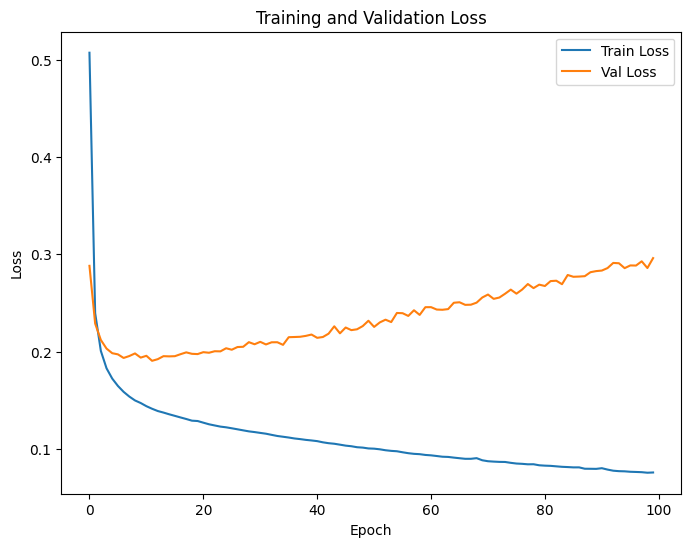

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
rgb_train, pm_train = next(iter(train_loader))
rgb_train = rgb_train[0]
pm_train = pm_train[0]

rgb_val, pm_val = next(iter(val_loader))
rgb_val = rgb_val[0]
pm_val = pm_val[0]

In [ ]:
with torch.no_grad():
    model.eval()

    rgb_train = rgb_train.unsqueeze(0).to(device)
    output_train = model(rgb_train)
    output_train = torch.argmax(output_train, dim=1).cpu().numpy()

    rgb_val = rgb_val.unsqueeze(0).to(device)
    output_val = model(rgb_val)
    output_val = torch.argmax(output_val, dim=1).cpu().numpy()

In [ ]:
# 모델 예측 결과를 시각화하는 함수
def visualize_result(rgb, pm_gt, pm_pred, is_train=True):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb.squeeze(0).permute(1, 2, 0).cpu(), aspect='auto')
    plt.colorbar()

    if is_train:
        plt.title('RGB Image (Train)')
    else:
        plt.title('RGB Image (Validation)')

    plt.subplot(1, 3, 2)
    plt.imshow(pm_gt, cmap='jet', vmin=0, vmax=5, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title('Pressure Map (Ground Truth)')

    plt.subplot(1, 3, 3)
    plt.imshow(pm_pred.squeeze(0), cmap='jet', vmin=0, vmax=5, aspect='auto')
    plt.colorbar(label='Class Label')
    plt.title('Pressure Map (Prediction)')

    plt.tight_layout()
    plt.show()

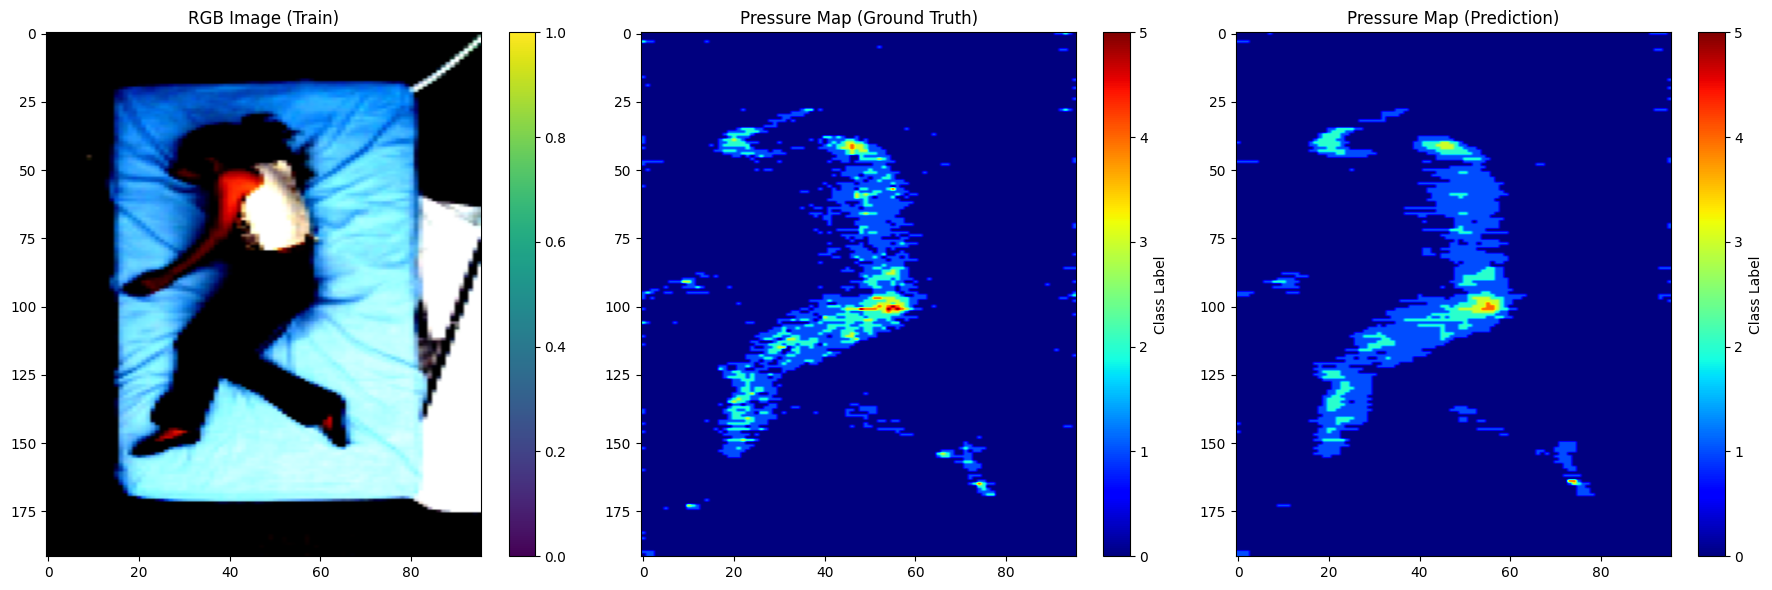

In [ ]:
# 훈련 데이터에 대한 결과 시각화
visualize_result(rgb_train, pm_train, output_train, True)

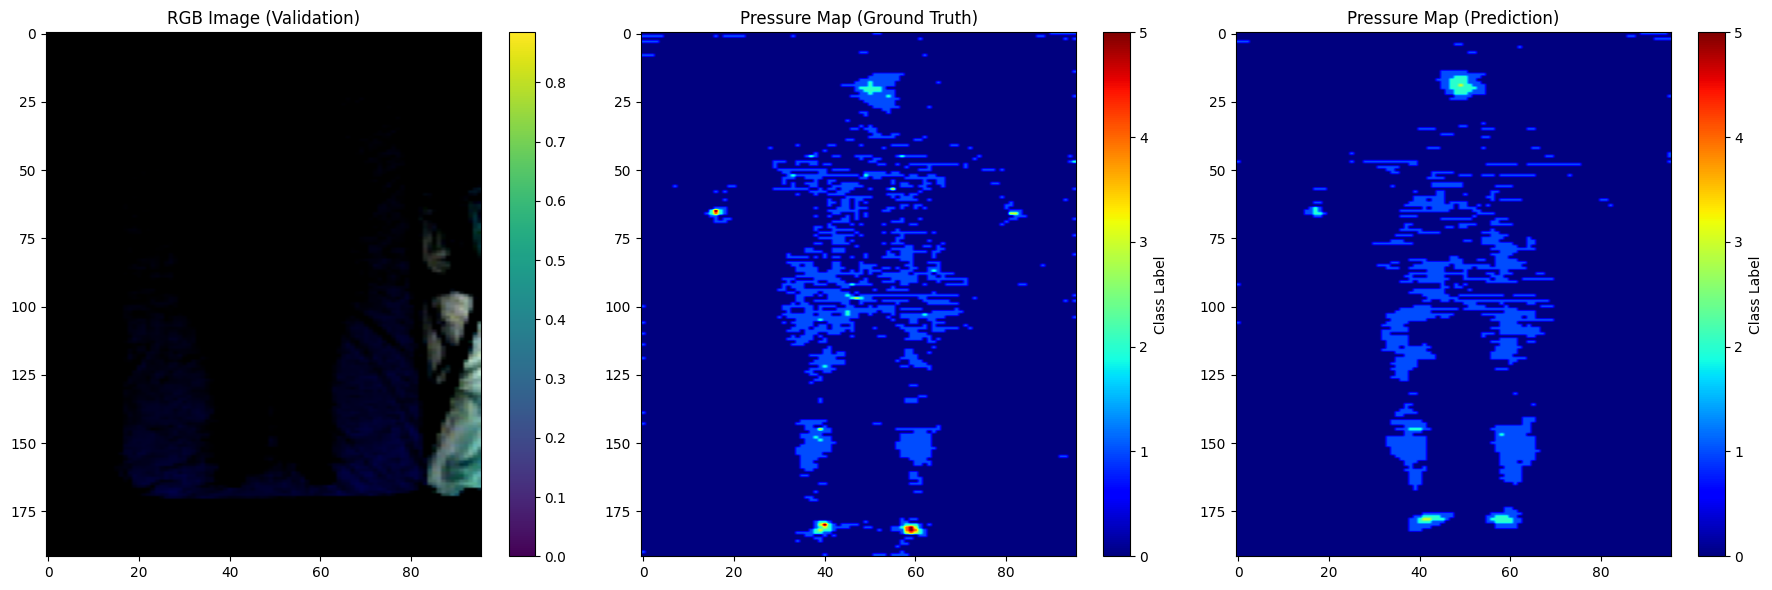

In [ ]:
# 검증 데이터에 대한 결과 시각화
visualize_result(rgb_val, pm_val, output_val, False)

In [ ]:
save_path = '/content/drive/MyDrive/SKKU_2-2 URP/[2] Pressure_Sore_Code/model_save'
if not os.path.exists(save_path):
    os.makedirs(save_path)

checkpoint_path = os.path.join(save_path, 'U-Net_100.pth')
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)